# **Mask R-CNN Implementation for Brain Tumor Segmentation**

In [18]:
import os 
os.getcwd() # Checking directory

'C:\\Users\\ilhan\\Mask_RCNN'

**Libraries**

In [19]:
# Importing libraries
import re
import sys
import cv2
import time
import json
import math
import random
import datetime
import numpy as np 
import pandas as pd 
import skimage.draw
import matplotlib.pyplot as plt

In [20]:
# Import libraries needed for Mask R-CNN 

# Root directory of the project
ROOT_DIR = os.path.abspath("")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
DEFAULT_LOGS_DIR = 'logs' 

In [21]:
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Import COCO config  
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))
import coco

plt.rcParams['figure.facecolor'] = 'white'

# Local path to dataset directory
DATASET_DIR = 'brain-tumor-segmentation/brain_tumor_data/'

**Configurations**

In [22]:
class BrainTumorConfig(Config):
    """Configuration for training on the brain tumor segmentation dataset.
    Derives from the base Config class and overrides values specific
    to the brain tumor segmentation dataset.
    """
    # Give the configuration a recognizable name
    NAME = "brain_tumor"

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + brain tumor

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

config = BrainTumorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

**Override the Mask R-CNN Dataset class**

Create a synthetic dataset for our own brain tumor dataset

Extend the Dataset class and add a method to load the shapes dataset, load_shapes(), and override the following methods:

*    load_image()
    
*    load_mask()
    
*    image_reference()

In [23]:
class BrainScanDataset(utils.Dataset):

    def load_brain_scan(self, dataset_dir, subset):
        """Load a subset of the FarmCow dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("tumor", 1, "tumor")

        # Train or validation dataset?
        assert subset in ["train", "val", 'test']
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(DATASET_DIR, subset, 'annotations'+'.json')))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "tumor",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, 
                height=height,
                polygons=polygons
            )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a farm_cow dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "tumor":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "tumor":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

**Create training,validation and test data**

In [24]:
# Training dataset.
dataset_train = BrainScanDataset()
dataset_train.load_brain_scan(DATASET_DIR, 'train')
dataset_train.prepare()

# Validation dataset
dataset_val = BrainScanDataset()
dataset_val.load_brain_scan(DATASET_DIR, 'val')
dataset_val.prepare()

# Test dataset
dataset_test = BrainScanDataset()
dataset_test.load_brain_scan(DATASET_DIR, 'test')
dataset_test.prepare()

**Visualization of masks**

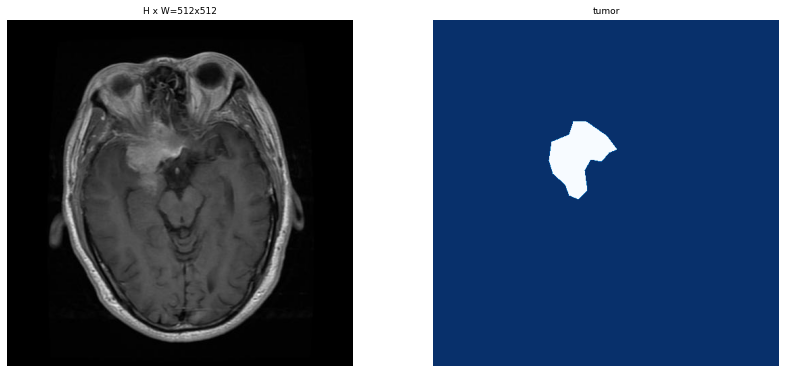

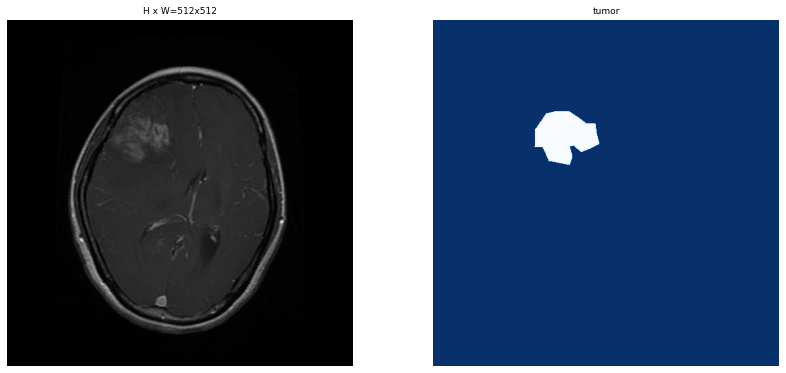

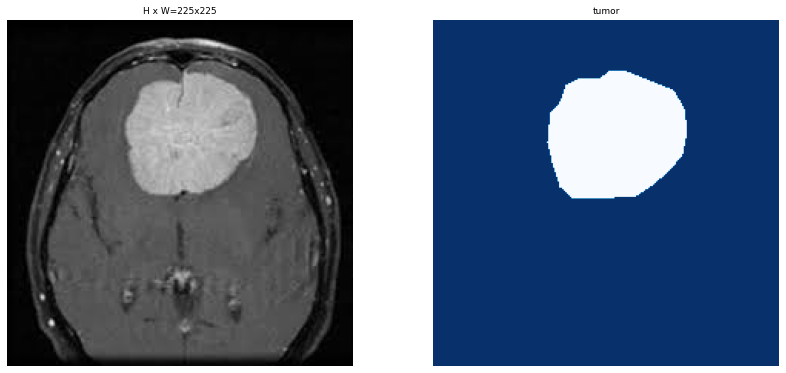

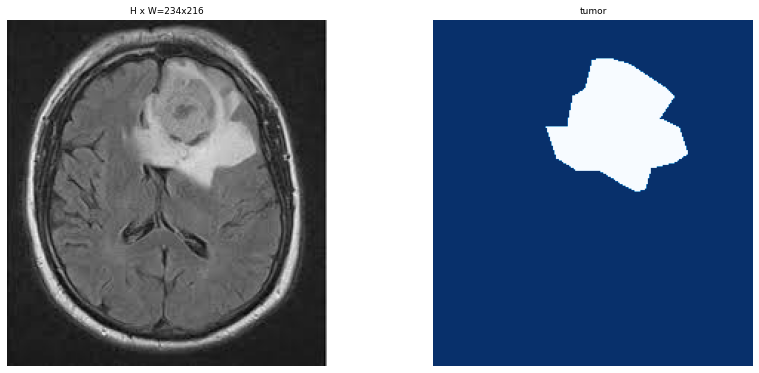

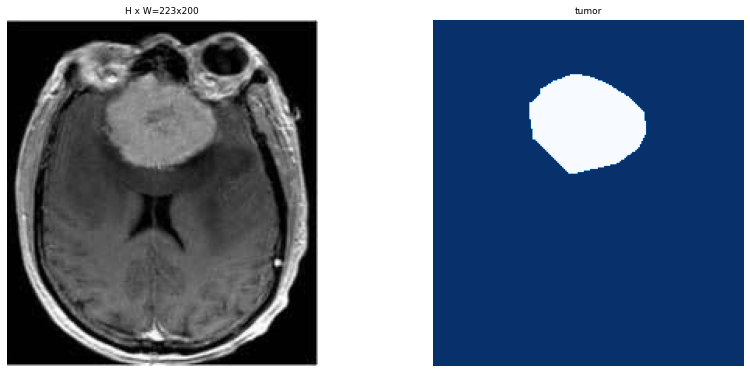

In [24]:
# Load and display 5 random samples
image_ids = np.random.choice(dataset_train.image_ids,5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names,1)

**Define the Mask R-CNN Model**

In [25]:
# Create model
model = modellib.MaskRCNN(
    mode='training', 
    config=config, 
    model_dir=DEFAULT_LOGS_DIR
)

# Load weights
model.load_weights(
    COCO_MODEL_PATH, 
    by_name=True, 
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
)

**Training**

In [24]:
# Since we're using a very small dataset, and starting from
# COCO trained weights, we don't need to train too long. Also,
# no need to train all layers, just the heads should do it.
print("Training network heads")
model.train(
    dataset_train, dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=15,
    layers='heads'
)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: logs\brain_tumor20221224T2131\mask_rcnn_brain_tumor_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)

In [33]:
# Saving weights after training
model.keras_model.save_weights('brain_tumor.h5')

In [26]:
class InferenceConfig(BrainTumorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
model_path = "brain_tumor.h5"

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  brain_tumor.h5


**Tumor Detection and Prediction**

In [57]:
def get_ax(rows=1, cols=1, size=12):
    
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  250.00000  uint8
image_meta               shape: (14,)                 min:    1.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  393.00000  max:  770.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


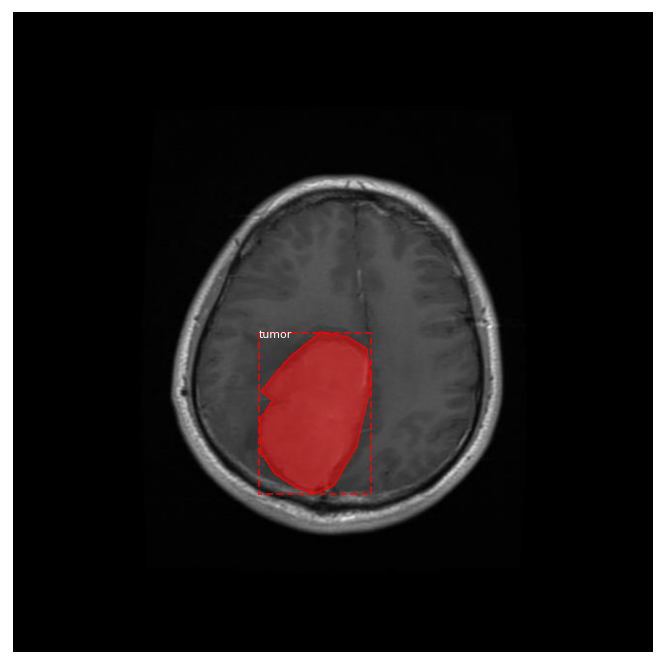

In [55]:
image_id=random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(12, 12))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  250.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


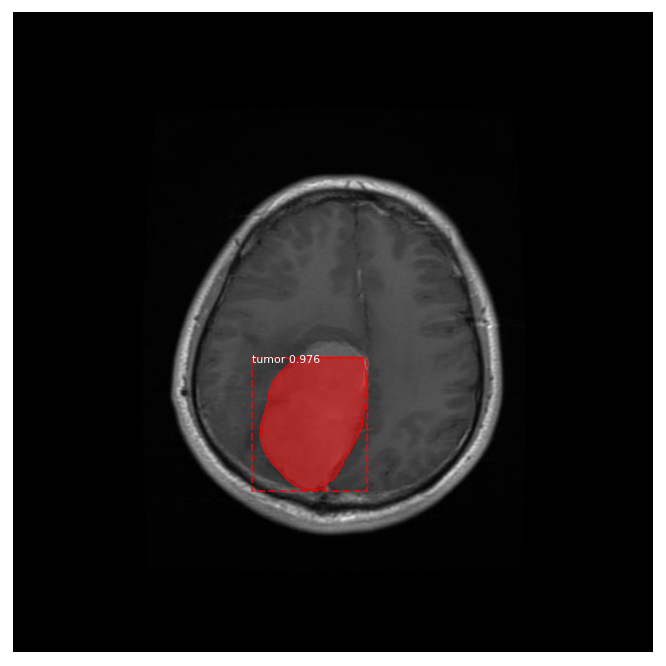

In [58]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [59]:
def predict_and_plot_differences(dataset, img_id):
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset, config, 
                               img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]
    if len(r['rois']):
        visualize.display_differences(
            original_image,
            gt_box, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            class_names = ['tumor'], title="", ax=get_ax(),
            show_mask=True, show_box=True)

In [62]:
# We display the original image without annotations first to visualize the differences
def display_image(dataset, ind):
    plt.figure(figsize=(12,12))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image')
    plt.show()

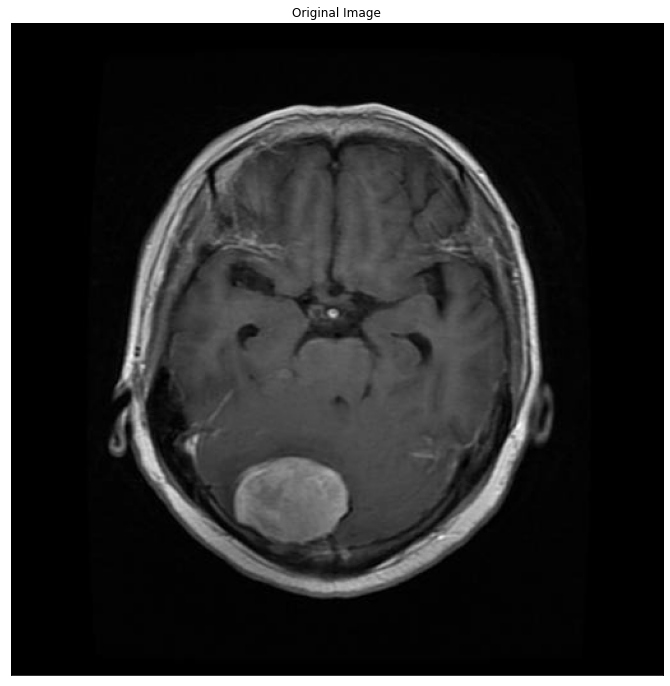

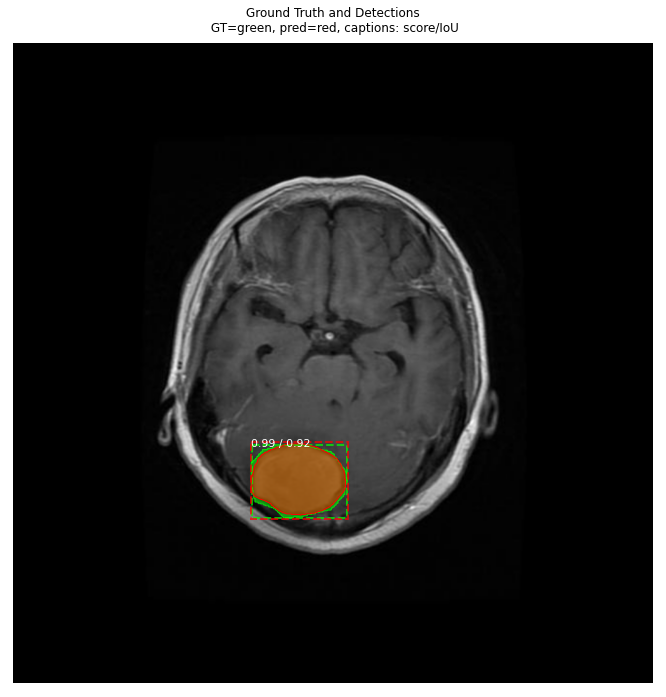

In [63]:
display_image(dataset_test, 6)
predict_and_plot_differences(dataset_test, 6)

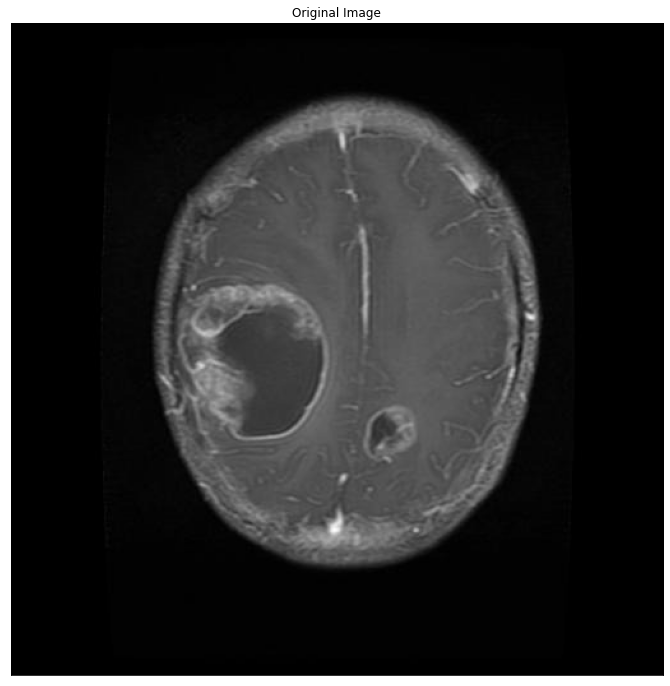

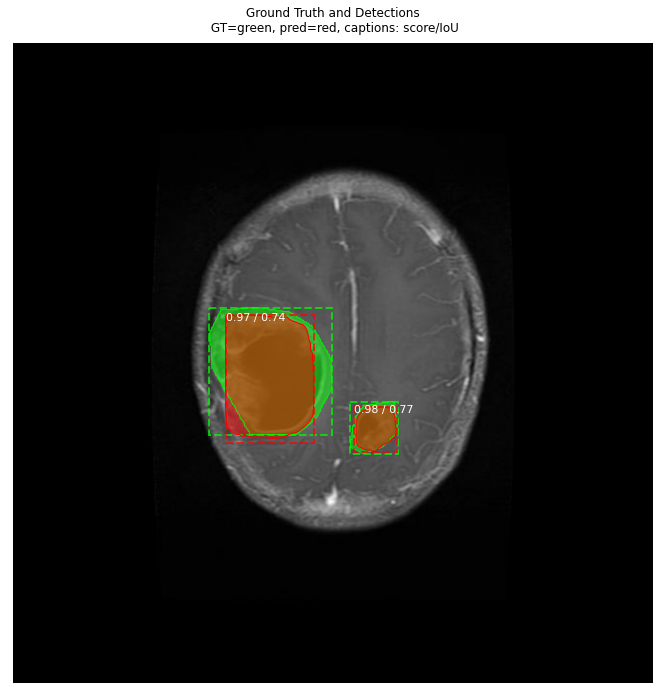

In [70]:
display_image(dataset_test, 28)
predict_and_plot_differences(dataset_test, 28)

**Evaluation**

In [44]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.8333333333333334


**Testing**

In [57]:
def display_top_masks_pred(image,image_id, mask, class_ids, class_names, predict_mask, limit=4):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("MRI " + str(image_id))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        titles.append('Ground Truth')
    
    predict_mask = np.sum(predict_mask * np.arange(1, predict_mask.shape[-1] + 1), -1)
    to_display.append(predict_mask)
    titles.append("Predict")

    visualize.display_images(to_display, titles=titles, cols=limit + 3, cmap="Blues_r")

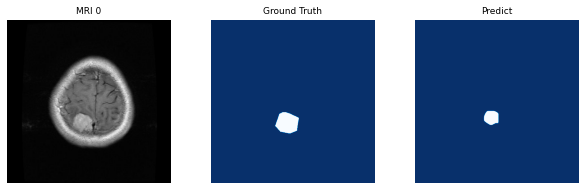

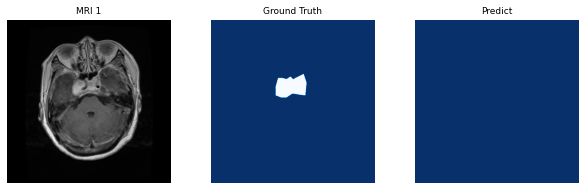

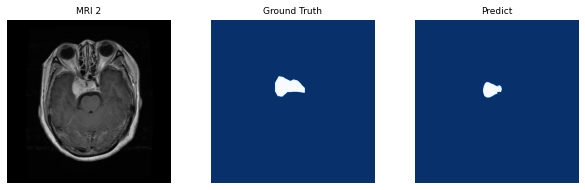

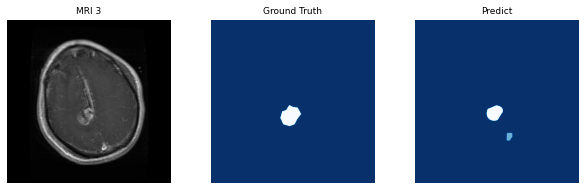

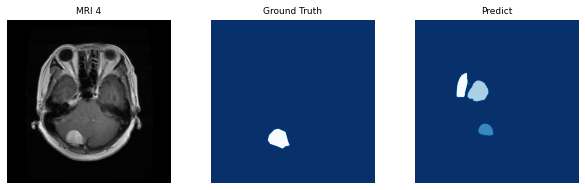

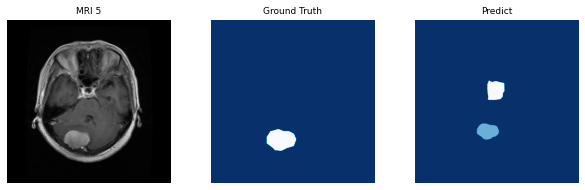

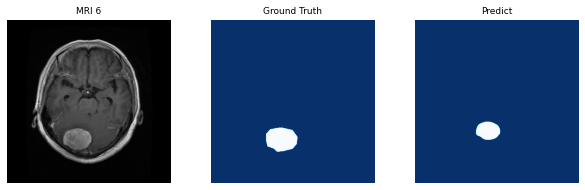

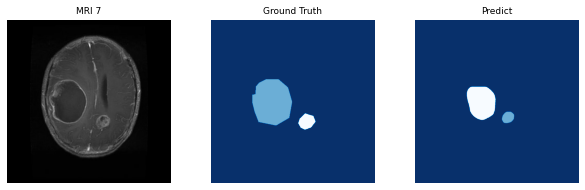

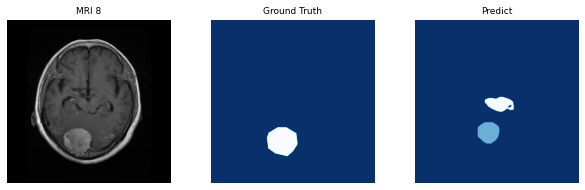

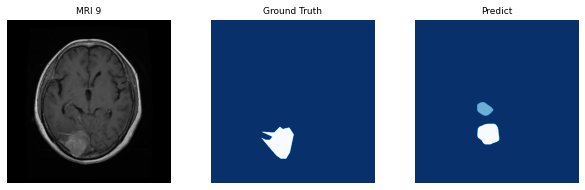

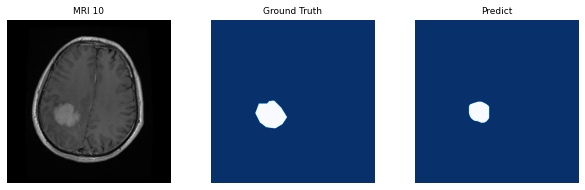

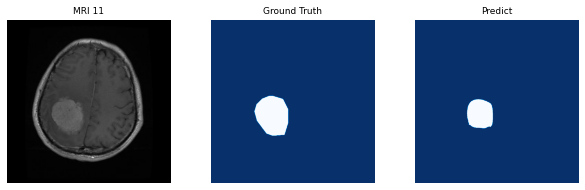

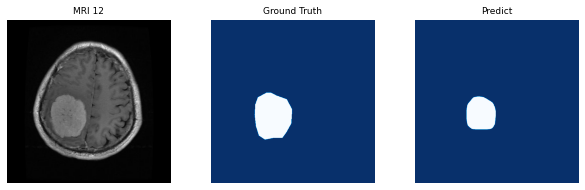

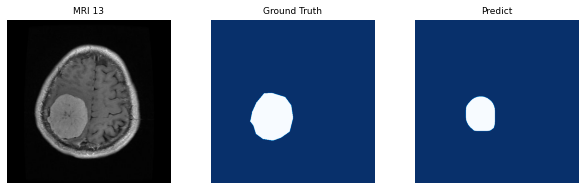

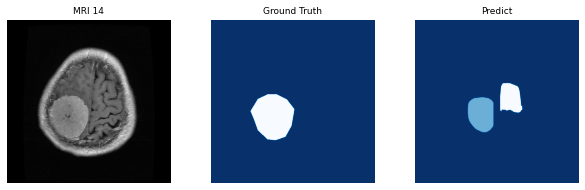

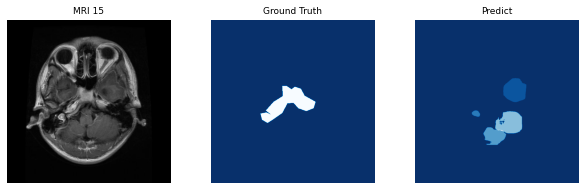

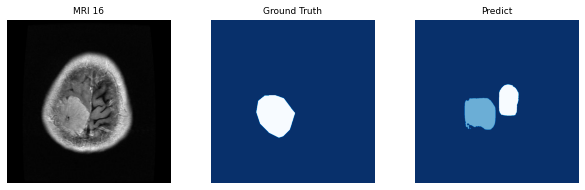

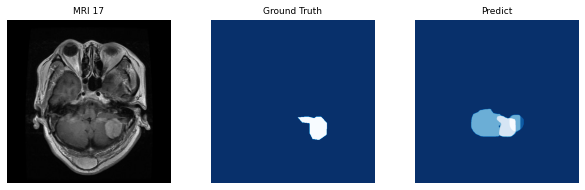

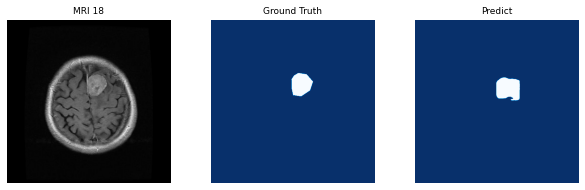

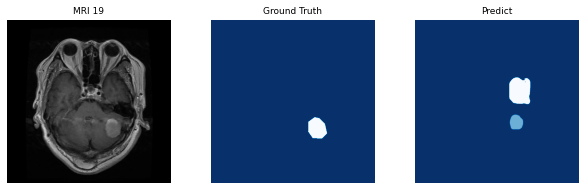

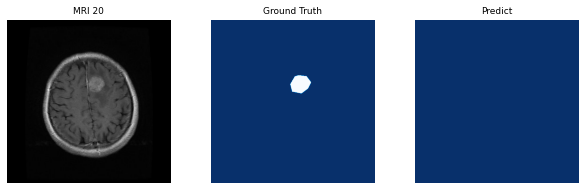

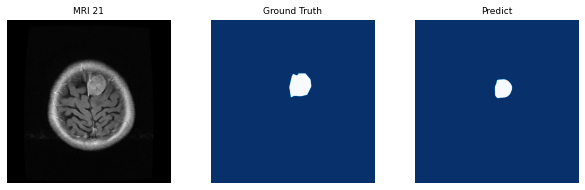

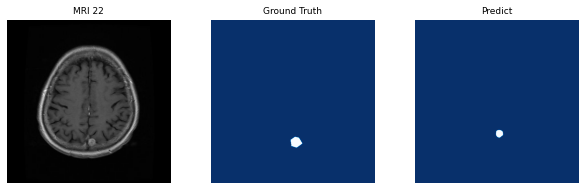

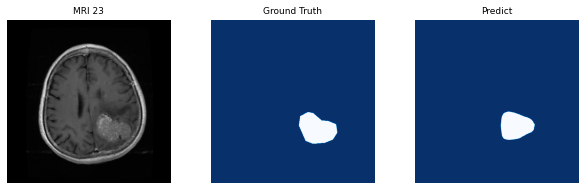

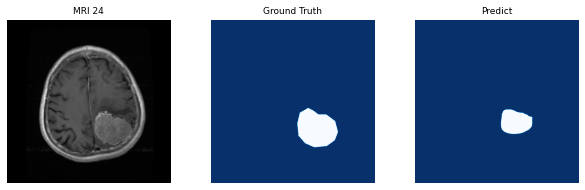

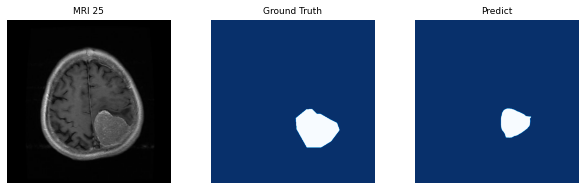

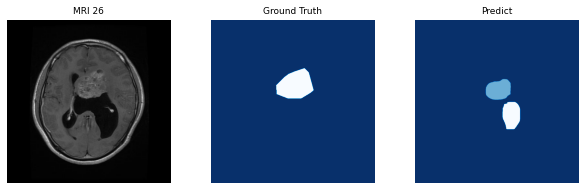

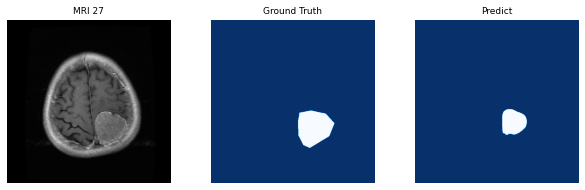

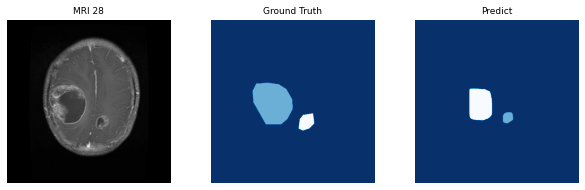

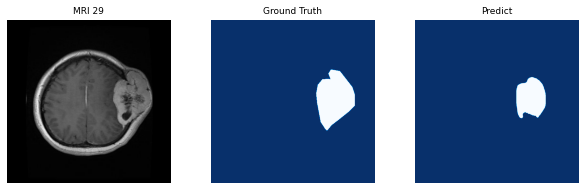

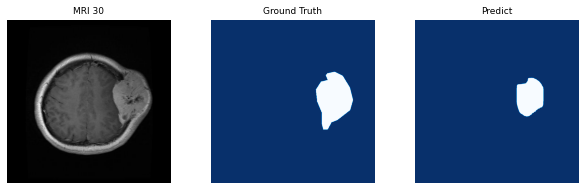

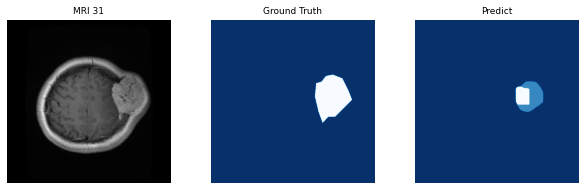

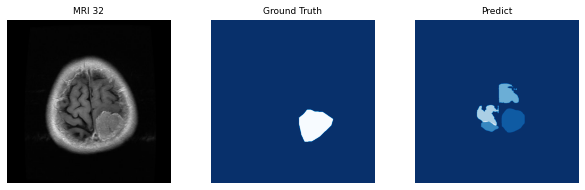

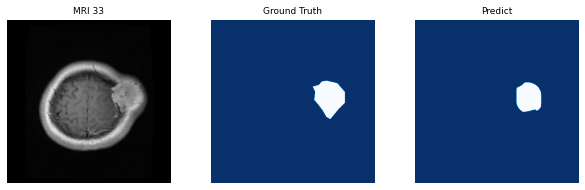

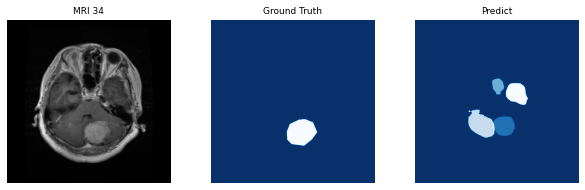

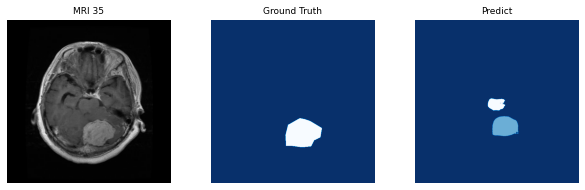

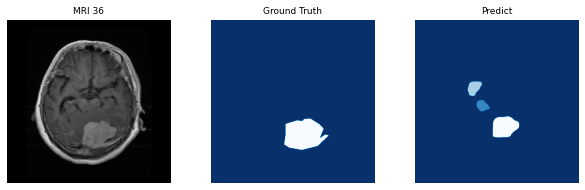

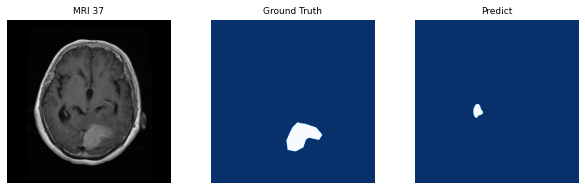

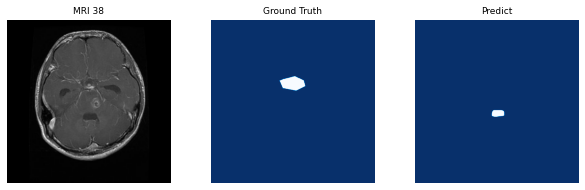

In [59]:
# We show the original MRI, the ground truth mask and the predict mask
for image_id in dataset_test.image_ids:
    image = dataset_test.load_image(image_id)
    mask, class_ids = dataset_test.load_mask(image_id)
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset_test, config, 
                               image_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    display_top_masks_pred(image, image_id, mask, class_ids, dataset_test.class_names, results[0]['masks'], limit=1)